## Introduction
League of legends is an online game in which two teams composed of five players each battles one another. The goal of the game is to destroy a structure situated in the enemy base and therefore there's no possibility of a draw. Games usually last about 25 to 30 minutes and during that time there are a series of events which can change the balance between the two teams: kills, towers destroyed, dragon taken and so on.

The aim of this project is to analyze, using a bayesian network, how the differents stats taken at the 10 minute mark of a game influence the final win.



In [77]:
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import BicScore

In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Dataset
The dataset used could be found [here](https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min).
This dataset contains the first 10min. stats of approx. 10k ranked games from a high ELO (DIAMOND I to MASTER). Players have roughly the same level.
There are 19 features per team (38 in total) collected after 10min in-game. This includes kills, deaths, gold, experience, level...

The column blueWins is the target value. A value of 1 means the blue team has won. 0 otherwise.

With the dataset there is also a nice analysis of data [here](https://www.kaggle.com/code/xiyuewang/lol-how-to-win).

For our purposes we decide to use as features, and aleatory variables, the differences between the two teams in differents statistics of the game.

The feature computed from the dataset are:
 1. blueWins: **1** blue teams wins **0** red team wins, there is no draw
 2. goldDiff: gold difference between the two teams. It is measure of how much a team is in advantage
 3. expDiff: experience difference between the two teams. Another measure of how much a team is in advantage
 4. killsDiff: compute as "bluesKills" - "blueDeaths", is the difference between the kills and the deaths of the blue team
 5. minionsDiff: computed as "blueTotalMinionsKilled" - "redTotalMinionsKilled", is the difference between the minions killed by the two teams
 6. towersDiff: computed as "blueTowersDestroyed" - "redTowersDestroyed". Towers are fortifications which defends the teams. The destruction of the towers is crucial to have an advantage
 7. dragonsDiff: computed as "blueDragons" - "redDragons". Dragons are enemies scattered in the map. Killing a dragon gives to the team additional stats.
 8. blueHeralds: Herald are enemies scattered in the map. Killing a Herald gives to the team a friendly minion which is very effective against the enemies tower.
 9. redHeralds: same as above.

In [79]:

def create_dataset(data):
    columns = ["blueWins", "blueGoldDiff", "blueExperienceDiff", "blueHeralds", "redHeralds"]
    dataset = data.loc[:, columns]
    dataset["killsDiff"] = data.apply(lambda row: row["blueKills"]-row["redKills"], axis=1)
    dataset["minionsDiff"] = data.apply(lambda row: row["blueTotalMinionsKilled"]-row["redTotalMinionsKilled"], axis=1)
    dataset["dragonsDiff"] = data.apply(lambda row: row["blueDragons"]-row["redDragons"], axis=1)
    dataset["towersDiff"] = data.apply(lambda row: row["blueTowersDestroyed"]-row["redTowersDestroyed"], axis=1)
    return dataset

## Discretization
Discretization is the process through which we can transform continuous variables, models or functions into a discrete form. We do this by creating a set of contiguous bins that go across the range of our desired variable.
First we compute our feature and after we discretize them using one of the following set of labels:
1. "True", "False": used for values that have only two possibile values.
    - blueWins
    - blueHeralds
    - redHeralds
2. "Negative", "Neutral", "Positive": used for all the statistics that usually are quite similar for both teams at 10 minutes game.
    - minionsDiff
    - dragonsDiff
    - towersDiff
2. "Very Negative", "Negative", "Neutral", "Positive", "Very Positive": used for the statistics that could be very different also at the start of the game
    - blueGoldDiff
    - blueExperienceDiff
    - killsDiff

The values are chosen in a way that the data are balanced between the bins.
We expect this type of ordering between the cardinality of the categories:

Neutral >~ Positive ≈ Negative > Very Positive ≈ Very Negative

In [80]:
def discretize(data):
    dataset = data.copy()
    negative_neutral_positive = ["Negative", "Neutral", "Positive"]
    negative_neutral_positive_aug = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]


    dataset["minionsDiff"] = pd.cut(dataset["minionsDiff"], bins=[-np.inf, -15, +15, np.inf], labels=negative_neutral_positive, include_lowest = True)
    dataset["dragonsDiff"] = pd.cut(dataset["dragonsDiff"], bins=[-np.inf, -1, 0, np.inf], labels=negative_neutral_positive, include_lowest = True)
    dataset["towersDiff"] = pd.cut(dataset["towersDiff"], bins=[-np.inf, -1, 0, np.inf], labels=negative_neutral_positive, include_lowest = True)

    
    dataset["blueGoldDiff"] = pd.cut(dataset["blueGoldDiff"], bins=[-np.inf, -2500, -1000, 1000, 2500, np.inf], labels=negative_neutral_positive_aug, include_lowest = True)
    dataset["blueExperienceDiff"] = pd.cut(dataset["blueExperienceDiff"], bins=[-np.inf,-2000,-750, 750, 2000, np.inf], labels=negative_neutral_positive_aug, include_lowest = True)
    dataset["killsDiff"] = pd.cut(dataset["killsDiff"], bins=[-np.inf,-4, -2, 2, 4, np.inf], labels=negative_neutral_positive_aug, include_lowest = True)


    true_false = {1: "True", 0: "False"}
    dataset = dataset.replace({"blueWins": true_false, "blueHeralds": true_false, "redHeralds": true_false})

    return dataset

In [81]:
path = "high_diamond_ranked_10min.csv"
data = pd.read_csv(path)
data.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [82]:
data_clean = create_dataset(data)
dataset = discretize(data_clean)
dataset.head()
for column in dataset:
    print(pd.value_counts(dataset[column]))


False    4949
True     4930
Name: blueWins, dtype: int64
Neutral          3248
Positive         1865
Negative         1819
Very Positive    1476
Very Negative    1471
Name: blueGoldDiff, dtype: int64
Neutral          3112
Negative         2004
Positive         1931
Very Negative    1457
Very Positive    1375
Name: blueExperienceDiff, dtype: int64
False    8022
True     1857
Name: blueHeralds, dtype: int64
False    8298
True     1581
Name: redHeralds, dtype: int64
Neutral          3671
Very Negative    1941
Negative         1550
Very Positive    1406
Positive         1311
Name: killsDiff, dtype: int64
Neutral     3769
Negative    3189
Positive    2921
Name: minionsDiff, dtype: int64
Negative    4081
Positive    3576
Neutral     2222
Name: dragonsDiff, dtype: int64
Neutral     9064
Positive     441
Negative     374
Name: towersDiff, dtype: int64


In [83]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   blueWins            9879 non-null   object  
 1   blueGoldDiff        9879 non-null   category
 2   blueExperienceDiff  9879 non-null   category
 3   blueHeralds         9879 non-null   object  
 4   redHeralds          9879 non-null   object  
 5   killsDiff           9879 non-null   category
 6   minionsDiff         9879 non-null   category
 7   dragonsDiff         9879 non-null   category
 8   towersDiff          9879 non-null   category
dtypes: category(6), object(3)
memory usage: 290.6+ KB


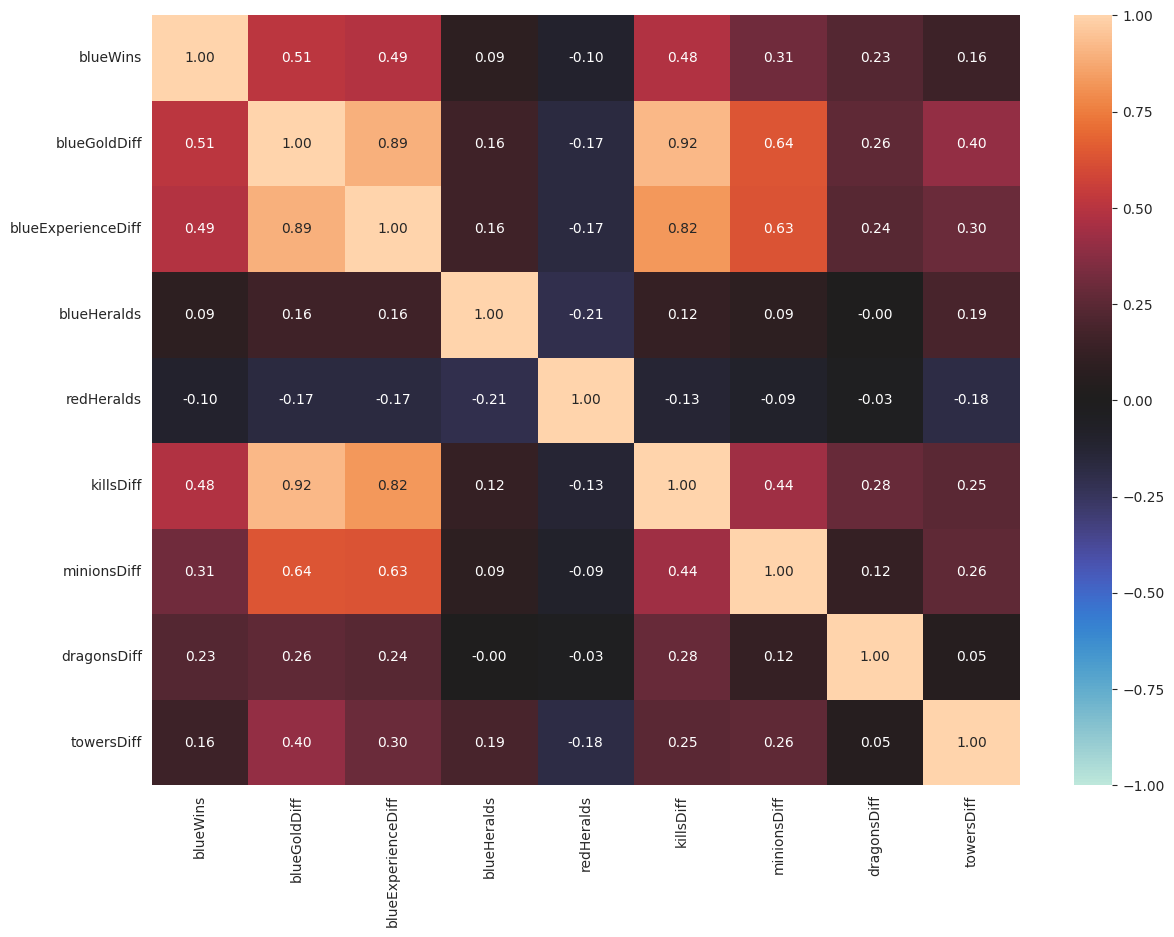

In [84]:
# Correlation matrix
def draw_correlation_matrix(dataset, figsize=(14, 10)):
    plt.figure(figsize=figsize)
    sns.heatmap(dataset.corr(), center=0, annot=True, fmt='.2f', vmin=-1, vmax=1)
#cmap='YlGnBu'
draw_correlation_matrix(data_clean)

# Bayesian networks
Let's build our bayesian network using two different approaches:
1. Manual approach: the net is built using our personal knoweldge of the topic.
2. Hillclimbing search: a greedy local search that starts from the DAG start (default: disconnected DAG)


In [85]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import pydot
import matplotlib.pyplot as plt

def draw_graph(model):
    pos = graphviz_layout(model, prog="dot")
    plt.figure(figsize=(10, 5))
    nx.draw(model, with_labels=True, pos=pos, node_size=3000, node_color="green")
    plt.savefig('model.png')
    plt.show()



## Manual Approach

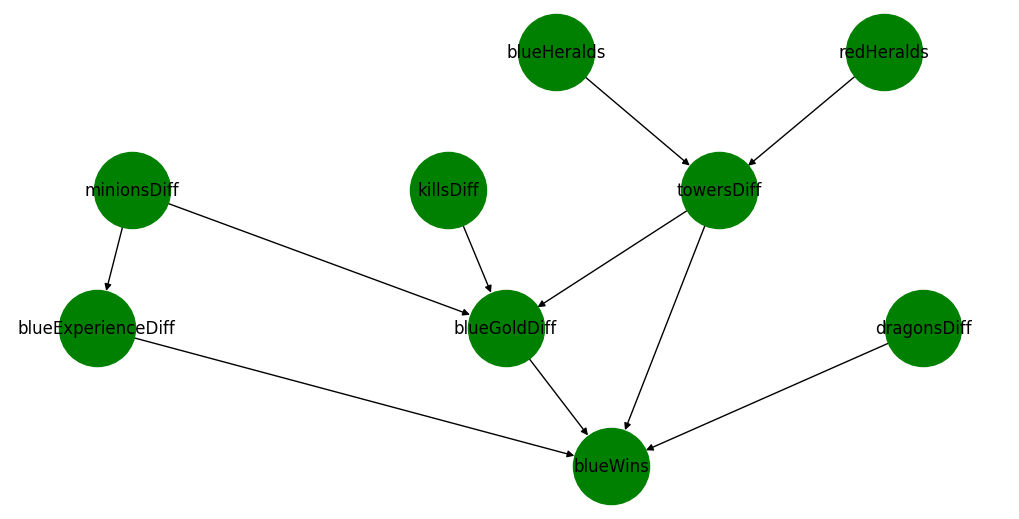

In [86]:
manual_model = BayesianNetwork([
    ("killsDiff", "blueGoldDiff"),
    ("minionsDiff", "blueGoldDiff"),
    ("minionsDiff", "blueExperienceDiff"),
    ("towersDiff", "blueGoldDiff"),
    ("towersDiff", "blueWins"),
    ("blueHeralds", "towersDiff"),
    ("redHeralds", "towersDiff"),
    ("dragonsDiff", "blueWins"),
    ("blueExperienceDiff", "blueWins"),
    ("blueGoldDiff", "blueWins")
])
draw_graph(manual_model)

## HillClimbing Search
The hill climb algorthm is a greedy local search for the DAG space (which is super-exponential). This strategy starts from a start DAG (usually a disconnected DAG) and proceeds by iteratively performing single-edge manipulations that maximally increase the score.
We have also added a **black list** to exclude all the edges outgoing the target node *blueWins* from the search.

  0%|          | 0/1000000 [00:00<?, ?it/s]

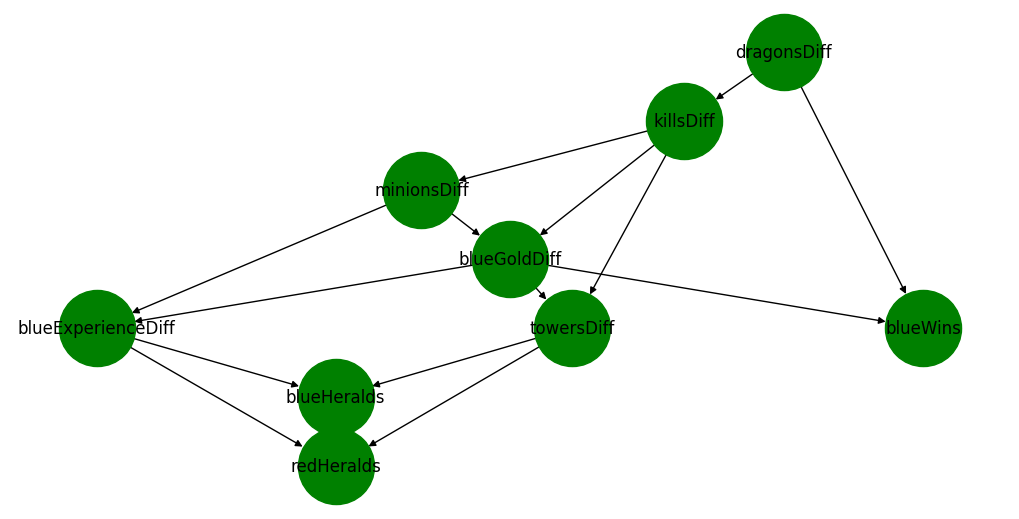

In [87]:
from pgmpy.estimators import HillClimbSearch, K2Score, ExhaustiveSearch, BicScore, BDeuScore, BDsScore, MmhcEstimator

estimator = HillClimbSearch(dataset)

black_list = [('blueWins', node) for node in dataset.columns[:-1]]
hillclimb_model = estimator.estimate(
    scoring_method=BDsScore(dataset), black_list=black_list)
hillclimb_model = BayesianNetwork(hillclimb_model)
draw_graph(hillclimb_model)


# Parameter Estimation


In [88]:
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator

manual_model.cpds = []

manual_model.fit(data=dataset,
            estimator=BayesianEstimator,
            prior_type="BDeu",
            equivalent_sample_size=10,
            complete_samples_only=False,
)

hillclimb_model.fit(data=dataset,
            estimator=BayesianEstimator,
            prior_type="BDeu",
            equivalent_sample_size=10,
            complete_samples_only=False,
)

#pd.options.display.max_columns = 2000

print(f"Check model: {manual_model.check_model()=}")
print(f"Check model: {hillclimb_model.check_model()=}")


for cpd in manual_model.get_cpds():
    print(f"CPT of {cpd.variable}")
    print(cpd)
    pass


Check model: manual_model.check_model()=True
Check model: hillclimb_model.check_model()=True
CPT of killsDiff
+--------------------------+----------+
| killsDiff(Negative)      | 0.156942 |
+--------------------------+----------+
| killsDiff(Neutral)       | 0.371423 |
+--------------------------+----------+
| killsDiff(Positive)      | 0.132774 |
+--------------------------+----------+
| killsDiff(Very Negative) | 0.196481 |
+--------------------------+----------+
| killsDiff(Very Positive) | 0.14238  |
+--------------------------+----------+
CPT of blueGoldDiff
+-----------------------------+-----+--------------------------+
| killsDiff                   | ... | killsDiff(Very Positive) |
+-----------------------------+-----+--------------------------+
| minionsDiff                 | ... | minionsDiff(Positive)    |
+-----------------------------+-----+--------------------------+
| towersDiff                  | ... | towersDiff(Positive)     |
+-----------------------------+-----+---

# Inference

In [89]:
from pgmpy.inference import VariableElimination
def queries(model):
    model_inference = VariableElimination(model)

    def print_query(target, evidence):
        value = model_inference.query(target, evidence)
        print(f"P({', '.join(target)} | {', '.join([f'{k}={v}' for (k, v) in evidence.items()])}): \n{value}\n")

    #blueWins, blueGoldDiff, towersDiff, killsDiff, blueExperienceDiff, blueHeralds, redHeralds, minionsDiff

    queries = [
        (["blueWins"], {"blueGoldDiff": "Positive"}),
        (["blueWins"], {"blueGoldDiff": "Very Positive"}),
        (["blueWins"], {"blueGoldDiff": "Positive", "towersDiff": "Positive"}),
        (["blueWins"], {"blueGoldDiff": "Positive", "towersDiff": "Negative"}),
        #(["blueWins"], {"blueGoldDiff": "Positive", "towersDiff": "Negative"}),
        (["blueWins"], {"blueGoldDiff": "Very Negative", "towersDiff": "Positive", "dragonsDiff": "Positive", "blueExperienceDiff": "Positive"}),
        (["blueGoldDiff"], {"blueWins": "True"}),

        # Active v-structure
        (["blueExperienceDiff"], {"dragonsDiff": "Positive", "blueWins": "True"}),
        (["killsDiff"], {"blueWins": "True"}),

        # Active v-structure long
        (["killsDiff"], {"blueHeralds": "True", "blueGoldDiff": "Positive"}),
        (["killsDiff"], {"blueHeralds": "False", "blueGoldDiff": "Positive"}),

        # Non active v-structure
        (["killsDiff"], {"blueHeralds": "True", "blueGoldDiff": "Positive", "towersDiff": "Positive"}),
        (["killsDiff"], {"blueHeralds": "False", "blueGoldDiff": "Positive", "towersDiff": "Positive"}),
    ]

    
    for query in queries:
        print_query(*query)


In [90]:
print("Handmade model")
queries(manual_model)
print("HillClimb model")
queries(hillclimb_model)


Handmade model


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

P(blueWins | blueGoldDiff=Positive): 
+-----------------+-----------------+
| blueWins        |   phi(blueWins) |
+=================+=================+
| blueWins(False) |          0.3227 |
+-----------------+-----------------+
| blueWins(True)  |          0.6773 |
+-----------------+-----------------+



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

P(blueWins | blueGoldDiff=Very Positive): 
+-----------------+-----------------+
| blueWins        |   phi(blueWins) |
+=================+=================+
| blueWins(False) |          0.2612 |
+-----------------+-----------------+
| blueWins(True)  |          0.7388 |
+-----------------+-----------------+



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P(blueWins | blueGoldDiff=Positive, towersDiff=Positive): 
+-----------------+-----------------+
| blueWins        |   phi(blueWins) |
+=================+=================+
| blueWins(False) |          0.3657 |
+-----------------+-----------------+
| blueWins(True)  |          0.6343 |
+-----------------+-----------------+



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P(blueWins | blueGoldDiff=Positive, towersDiff=Negative): 
+-----------------+-----------------+
| blueWins        |   phi(blueWins) |
+=================+=================+
| blueWins(False) |          0.4138 |
+-----------------+-----------------+
| blueWins(True)  |          0.5862 |
+-----------------+-----------------+



0it [00:00, ?it/s]

0it [00:00, ?it/s]

P(blueWins | blueGoldDiff=Very Negative, towersDiff=Positive, dragonsDiff=Positive, blueExperienceDiff=Positive): 
+-----------------+-----------------+
| blueWins        |   phi(blueWins) |
+=================+=================+
| blueWins(False) |          0.5000 |
+-----------------+-----------------+
| blueWins(True)  |          0.5000 |
+-----------------+-----------------+



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

P(blueGoldDiff | blueWins=True): 
+-----------------------------+---------------------+
| blueGoldDiff                |   phi(blueGoldDiff) |
+=============================+=====================+
| blueGoldDiff(Negative)      |              0.1244 |
+-----------------------------+---------------------+
| blueGoldDiff(Neutral)       |              0.3696 |
+-----------------------------+---------------------+
| blueGoldDiff(Positive)      |              0.2758 |
+-----------------------------+---------------------+
| blueGoldDiff(Very Negative) |              0.0536 |
+-----------------------------+---------------------+
| blueGoldDiff(Very Positive) |              0.1766 |
+-----------------------------+---------------------+



  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

P(blueExperienceDiff | dragonsDiff=Positive, blueWins=True): 
+-----------------------------------+---------------------------+
| blueExperienceDiff                |   phi(blueExperienceDiff) |
+===================================+===========================+
| blueExperienceDiff(Negative)      |                    0.1603 |
+-----------------------------------+---------------------------+
| blueExperienceDiff(Neutral)       |                    0.3127 |
+-----------------------------------+---------------------------+
| blueExperienceDiff(Positive)      |                    0.2278 |
+-----------------------------------+---------------------------+
| blueExperienceDiff(Very Negative) |                    0.0984 |
+-----------------------------------+---------------------------+
| blueExperienceDiff(Very Positive) |                    0.2008 |
+-----------------------------------+---------------------------+



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

P(killsDiff | blueWins=True): 
+--------------------------+------------------+
| killsDiff                |   phi(killsDiff) |
+==========================+==================+
| killsDiff(Negative)      |           0.1254 |
+--------------------------+------------------+
| killsDiff(Neutral)       |           0.3866 |
+--------------------------+------------------+
| killsDiff(Positive)      |           0.1688 |
+--------------------------+------------------+
| killsDiff(Very Negative) |           0.1227 |
+--------------------------+------------------+
| killsDiff(Very Positive) |           0.1966 |
+--------------------------+------------------+



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

P(killsDiff | blueHeralds=True, blueGoldDiff=Positive): 
+--------------------------+------------------+
| killsDiff                |   phi(killsDiff) |
+==========================+==================+
| killsDiff(Negative)      |           0.0318 |
+--------------------------+------------------+
| killsDiff(Neutral)       |           0.4274 |
+--------------------------+------------------+
| killsDiff(Positive)      |           0.3277 |
+--------------------------+------------------+
| killsDiff(Very Negative) |           0.0129 |
+--------------------------+------------------+
| killsDiff(Very Positive) |           0.2002 |
+--------------------------+------------------+



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

P(killsDiff | blueHeralds=False, blueGoldDiff=Positive): 
+--------------------------+------------------+
| killsDiff                |   phi(killsDiff) |
+==========================+==================+
| killsDiff(Negative)      |           0.0092 |
+--------------------------+------------------+
| killsDiff(Neutral)       |           0.3717 |
+--------------------------+------------------+
| killsDiff(Positive)      |           0.3765 |
+--------------------------+------------------+
| killsDiff(Very Negative) |           0.0033 |
+--------------------------+------------------+
| killsDiff(Very Positive) |           0.2393 |
+--------------------------+------------------+



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

P(killsDiff | blueHeralds=True, blueGoldDiff=Positive, towersDiff=Positive): 
+--------------------------+------------------+
| killsDiff                |   phi(killsDiff) |
+==========================+==================+
| killsDiff(Negative)      |           0.1113 |
+--------------------------+------------------+
| killsDiff(Neutral)       |           0.6502 |
+--------------------------+------------------+
| killsDiff(Positive)      |           0.1632 |
+--------------------------+------------------+
| killsDiff(Very Negative) |           0.0463 |
+--------------------------+------------------+
| killsDiff(Very Positive) |           0.0291 |
+--------------------------+------------------+



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

P(killsDiff | blueHeralds=False, blueGoldDiff=Positive, towersDiff=Positive): 
+--------------------------+------------------+
| killsDiff                |   phi(killsDiff) |
+==========================+==================+
| killsDiff(Negative)      |           0.1113 |
+--------------------------+------------------+
| killsDiff(Neutral)       |           0.6502 |
+--------------------------+------------------+
| killsDiff(Positive)      |           0.1632 |
+--------------------------+------------------+
| killsDiff(Very Negative) |           0.0463 |
+--------------------------+------------------+
| killsDiff(Very Positive) |           0.0291 |
+--------------------------+------------------+

HillClimb model


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

P(blueWins | blueGoldDiff=Positive): 
+-----------------+-----------------+
| blueWins        |   phi(blueWins) |
+=================+=================+
| blueWins(False) |          0.2696 |
+-----------------+-----------------+
| blueWins(True)  |          0.7304 |
+-----------------+-----------------+



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

P(blueWins | blueGoldDiff=Very Positive): 
+-----------------+-----------------+
| blueWins        |   phi(blueWins) |
+=================+=================+
| blueWins(False) |          0.1214 |
+-----------------+-----------------+
| blueWins(True)  |          0.8786 |
+-----------------+-----------------+



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

P(blueWins | blueGoldDiff=Positive, towersDiff=Positive): 
+-----------------+-----------------+
| blueWins        |   phi(blueWins) |
+=================+=================+
| blueWins(False) |          0.2765 |
+-----------------+-----------------+
| blueWins(True)  |          0.7235 |
+-----------------+-----------------+



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

P(blueWins | blueGoldDiff=Positive, towersDiff=Negative): 
+-----------------+-----------------+
| blueWins        |   phi(blueWins) |
+=================+=================+
| blueWins(False) |          0.2632 |
+-----------------+-----------------+
| blueWins(True)  |          0.7368 |
+-----------------+-----------------+



0it [00:00, ?it/s]

0it [00:00, ?it/s]

P(blueWins | blueGoldDiff=Very Negative, towersDiff=Positive, dragonsDiff=Positive, blueExperienceDiff=Positive): 
+-----------------+-----------------+
| blueWins        |   phi(blueWins) |
+=================+=================+
| blueWins(False) |          0.8230 |
+-----------------+-----------------+
| blueWins(True)  |          0.1770 |
+-----------------+-----------------+



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

P(blueGoldDiff | blueWins=True): 
+-----------------------------+---------------------+
| blueGoldDiff                |   phi(blueGoldDiff) |
+=============================+=====================+
| blueGoldDiff(Negative)      |              0.0987 |
+-----------------------------+---------------------+
| blueGoldDiff(Neutral)       |              0.3262 |
+-----------------------------+---------------------+
| blueGoldDiff(Positive)      |              0.2764 |
+-----------------------------+---------------------+
| blueGoldDiff(Very Negative) |              0.0355 |
+-----------------------------+---------------------+
| blueGoldDiff(Very Positive) |              0.2632 |
+-----------------------------+---------------------+



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

P(blueExperienceDiff | dragonsDiff=Positive, blueWins=True): 
+-----------------------------------+---------------------------+
| blueExperienceDiff                |   phi(blueExperienceDiff) |
+===================================+===========================+
| blueExperienceDiff(Negative)      |                    0.1145 |
+-----------------------------------+---------------------------+
| blueExperienceDiff(Neutral)       |                    0.3000 |
+-----------------------------------+---------------------------+
| blueExperienceDiff(Positive)      |                    0.2809 |
+-----------------------------------+---------------------------+
| blueExperienceDiff(Very Negative) |                    0.0370 |
+-----------------------------------+---------------------------+
| blueExperienceDiff(Very Positive) |                    0.2675 |
+-----------------------------------+---------------------------+



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

P(killsDiff | blueWins=True): 
+--------------------------+------------------+
| killsDiff                |   phi(killsDiff) |
+==========================+==================+
| killsDiff(Negative)      |           0.1055 |
+--------------------------+------------------+
| killsDiff(Neutral)       |           0.3915 |
+--------------------------+------------------+
| killsDiff(Positive)      |           0.1926 |
+--------------------------+------------------+
| killsDiff(Very Negative) |           0.0688 |
+--------------------------+------------------+
| killsDiff(Very Positive) |           0.2416 |
+--------------------------+------------------+



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P(killsDiff | blueHeralds=True, blueGoldDiff=Positive): 
+--------------------------+------------------+
| killsDiff                |   phi(killsDiff) |
+==========================+==================+
| killsDiff(Negative)      |           0.0180 |
+--------------------------+------------------+
| killsDiff(Neutral)       |           0.4545 |
+--------------------------+------------------+
| killsDiff(Positive)      |           0.3858 |
+--------------------------+------------------+
| killsDiff(Very Negative) |           0.0022 |
+--------------------------+------------------+
| killsDiff(Very Positive) |           0.1395 |
+--------------------------+------------------+



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P(killsDiff | blueHeralds=False, blueGoldDiff=Positive): 
+--------------------------+------------------+
| killsDiff                |   phi(killsDiff) |
+==========================+==================+
| killsDiff(Negative)      |           0.0068 |
+--------------------------+------------------+
| killsDiff(Neutral)       |           0.4115 |
+--------------------------+------------------+
| killsDiff(Positive)      |           0.4211 |
+--------------------------+------------------+
| killsDiff(Very Negative) |           0.0010 |
+--------------------------+------------------+
| killsDiff(Very Positive) |           0.1595 |
+--------------------------+------------------+



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

P(killsDiff | blueHeralds=True, blueGoldDiff=Positive, towersDiff=Positive): 
+--------------------------+------------------+
| killsDiff                |   phi(killsDiff) |
+==========================+==================+
| killsDiff(Negative)      |           0.0939 |
+--------------------------+------------------+
| killsDiff(Neutral)       |           0.7254 |
+--------------------------+------------------+
| killsDiff(Positive)      |           0.1502 |
+--------------------------+------------------+
| killsDiff(Very Negative) |           0.0105 |
+--------------------------+------------------+
| killsDiff(Very Positive) |           0.0199 |
+--------------------------+------------------+



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

P(killsDiff | blueHeralds=False, blueGoldDiff=Positive, towersDiff=Positive): 
+--------------------------+------------------+
| killsDiff                |   phi(killsDiff) |
+==========================+==================+
| killsDiff(Negative)      |           0.0945 |
+--------------------------+------------------+
| killsDiff(Neutral)       |           0.7261 |
+--------------------------+------------------+
| killsDiff(Positive)      |           0.1493 |
+--------------------------+------------------+
| killsDiff(Very Negative) |           0.0106 |
+--------------------------+------------------+
| killsDiff(Very Positive) |           0.0196 |
+--------------------------+------------------+



# Indipendence and Markov blanket

In [91]:
def active_trails_of(query, evidence, model):
    active = model.active_trail_nodes(query, observed=evidence).get(query)
    active.remove(query)
    if active:
        if evidence:
            print(f'Active trails between \'{query}\' and {active} given the evidence {set(evidence)}.')
        else:
            print(f'Active trails between \'{query}\' and {active} given no evidence.')
    else:
        print(f'No active trails for \'{query}\' given the evidence {set(evidence)}.')

active_trails_of("blueGoldDiff", ["blueWins", "towersDiff"], manual_model)
active_trails_of("blueGoldDiff", ["blueWins", "towersDiff"], hillclimb_model)




def markov_blanket_of(node, model):
    print(f'Markov blanket of \'{node}\' is {set(model.get_markov_blanket(node))}')

    return 

markov_blanket_of('blueGoldDiff', manual_model)
markov_blanket_of('blueGoldDiff', hillclimb_model)


Active trails between 'blueGoldDiff' and {'minionsDiff', 'killsDiff', 'blueExperienceDiff', 'dragonsDiff'} given the evidence {'blueWins', 'towersDiff'}.
Active trails between 'blueGoldDiff' and {'blueHeralds', 'minionsDiff', 'killsDiff', 'redHeralds', 'blueExperienceDiff', 'dragonsDiff'} given the evidence {'blueWins', 'towersDiff'}.
Markov blanket of 'blueGoldDiff' is {'minionsDiff', 'towersDiff', 'blueExperienceDiff', 'dragonsDiff', 'blueWins', 'killsDiff'}
Markov blanket of 'blueGoldDiff' is {'minionsDiff', 'towersDiff', 'blueExperienceDiff', 'dragonsDiff', 'blueWins', 'killsDiff'}


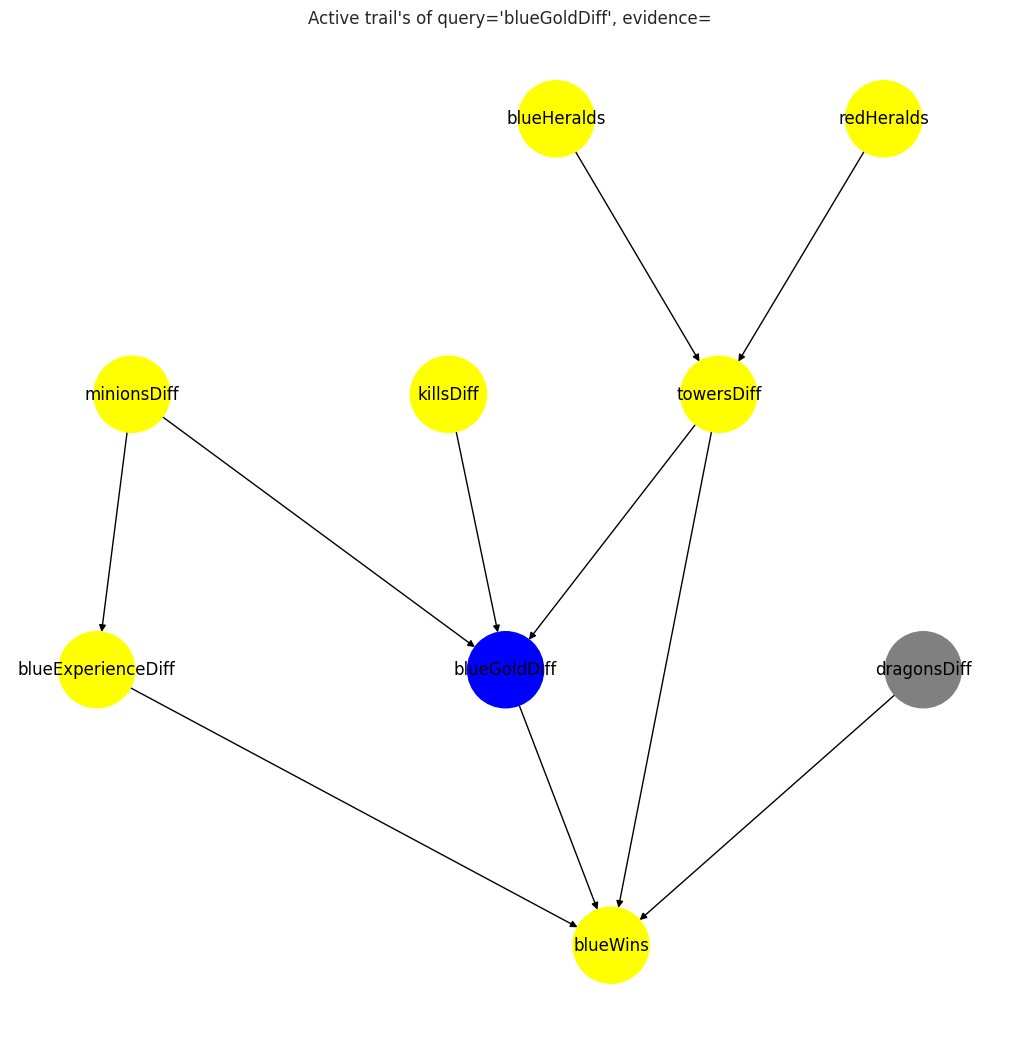

In [92]:
def draw_graph(model, color="green", title="", figsize=(10, 10)):
    pos = graphviz_layout(model, prog="dot")
    plt.figure(figsize=figsize)
    nx.draw(model, with_labels=True, pos=pos, node_size=3000, node_color=color)
    plt.savefig('model.png')
    plt.title(title)
    plt.show()


def draw_markov_blanket_of(node, model):
    blanket = model.get_markov_blanket(node)
    color = ["yellow" if n in blanket else "blue" if n == node else "gray" for n in model.nodes]

    draw_graph(model, color, f"Markov's blanket of {node}")

def draw_active_trail_of(query, evidence, model):
    active = model.active_trail_nodes(query, observed=evidence).get(query)
    active.remove(query)
    color = ["yellow" if n in active else "blue" if n == query else "red" if n in evidence else "gray" for n in model.nodes]

    draw_graph(model, color, f"Active trail's of {query=}, evidence={', '.join(evidence)}")

def draw_indipendencies(node, model):
    draw_active_trail_of(node, [], model)


#draw_markov_blanket_of("blueGoldDiff", manual_model)
#draw_markov_blanket_of("blueHeralds", manual_model)
#draw_active_trail_of("blueGoldDiff", ["blueWins", "towersDiff"], manual_model)
draw_indipendencies("blueGoldDiff", manual_model)

#active_trails_of


# Complete dataset test
In this section we will use the entire dataset to compute our DAG using the Hill Climbing search.
After we will compare this model with the others. The aim is to understand how much the absence of all the feature influence the model and its results.

In [93]:
def discretize_complete(data):
    dataset = data.copy()

    negative_neutral_positive = ["Negative", "Neutral", "Positive"]
    negative_neutral_positive_aug = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]

    neutral_positive = ["Neutral", "Positive"]
    neutral_positive_aug = ["Neutral", "Positive", "Very Positive"]


    true_false_dict = {1: "True", 0: "False"}
    true_false_list = ["blueWins", "blueHeralds", "redHeralds", "blueFirstBlood", "redFirstBlood", "blueDragons", "redDragons"]
    to_replace = {v: true_false_dict for v in true_false_list}
    dataset = dataset.replace(to_replace)

    def cut_red_and_blue(key, bins, labels):
        blue_key = f"blue{key}"
        red_key = f"red{key}"

        if blue_key in dataset:
            dataset[blue_key] = pd.cut(dataset[blue_key], bins=bins, labels=labels, include_lowest=True)
        if red_key in dataset:
            dataset[red_key] = pd.cut(dataset[red_key], bins=bins, labels=labels, include_lowest=True)

    cut_red_and_blue("WardsPlaced", [-np.inf, 12, 25, np.inf], neutral_positive_aug)
    cut_red_and_blue("WardsDestroyed", [-np.inf, 4, 8, np.inf], neutral_positive_aug)
    cut_red_and_blue("Kills", [-np.inf, 5, 9, np.inf], neutral_positive_aug)
    cut_red_and_blue("Deaths", [-np.inf, 5, 9, np.inf], neutral_positive_aug)
    cut_red_and_blue("Assists", [-np.inf, 7, 11, np.inf], neutral_positive_aug)
    cut_red_and_blue("EliteMonsters", [-np.inf, 1, 2, np.inf], neutral_positive_aug)
    cut_red_and_blue("TowersDestroyed", [-np.inf, 1, 2, np.inf], neutral_positive_aug)
    cut_red_and_blue("TotalGold", [-np.inf, 13000, 17000, np.inf], neutral_positive_aug)
    cut_red_and_blue("AvgLevel", [-np.inf, 7, 8, np.inf], neutral_positive_aug)
    cut_red_and_blue("TotalExperience", [-np.inf, 17000, 18000, np.inf], neutral_positive_aug)
    cut_red_and_blue("TotalMinionsKilled", [-np.inf, 180, 220, np.inf], neutral_positive_aug)
    cut_red_and_blue("TotalJungleMinionsKilled", [-np.inf, 45, 60, np.inf], neutral_positive_aug)
    cut_red_and_blue("GoldDiff", [-np.inf, -2500, -1000, 1000, 2500, np.inf], negative_neutral_positive_aug)
    cut_red_and_blue("ExperienceDiff", [-np.inf,-2000,-750, 750, 2000, np.inf], negative_neutral_positive_aug)
    cut_red_and_blue("CSPerMin", [-np.inf, 20, 24, np.inf], neutral_positive_aug)
    cut_red_and_blue("GoldPerMin", [-np.inf, 1462, 1851, np.inf], neutral_positive_aug)

    return dataset

path = "high_diamond_ranked_10min.csv"
data = pd.read_csv(path)
data = data.drop("gameId", axis=1)

dataset_complete = discretize_complete(data)
dataset_complete.head()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,False,Very Positive,Neutral,True,Positive,Positive,Positive,Neutral,False,False,...,Neutral,Positive,Neutral,Positive,Positive,Positive,Neutral,Neutral,Neutral,Positive
1,False,Neutral,Neutral,False,Neutral,Neutral,Neutral,Neutral,False,False,...,Neutral,Very Positive,Neutral,Positive,Very Positive,Positive,Very Positive,Positive,Positive,Positive
2,False,Positive,Neutral,False,Positive,Very Positive,Neutral,Neutral,True,False,...,Neutral,Very Positive,Neutral,Positive,Positive,Neutral,Positive,Positive,Positive,Positive
3,False,Very Positive,Neutral,False,Neutral,Neutral,Neutral,Neutral,False,True,...,Neutral,Positive,Neutral,Positive,Very Positive,Positive,Positive,Neutral,Positive,Positive
4,False,Very Positive,Neutral,False,Positive,Positive,Neutral,Neutral,False,False,...,Neutral,Very Positive,Neutral,Very Positive,Very Positive,Very Positive,Positive,Neutral,Positive,Positive


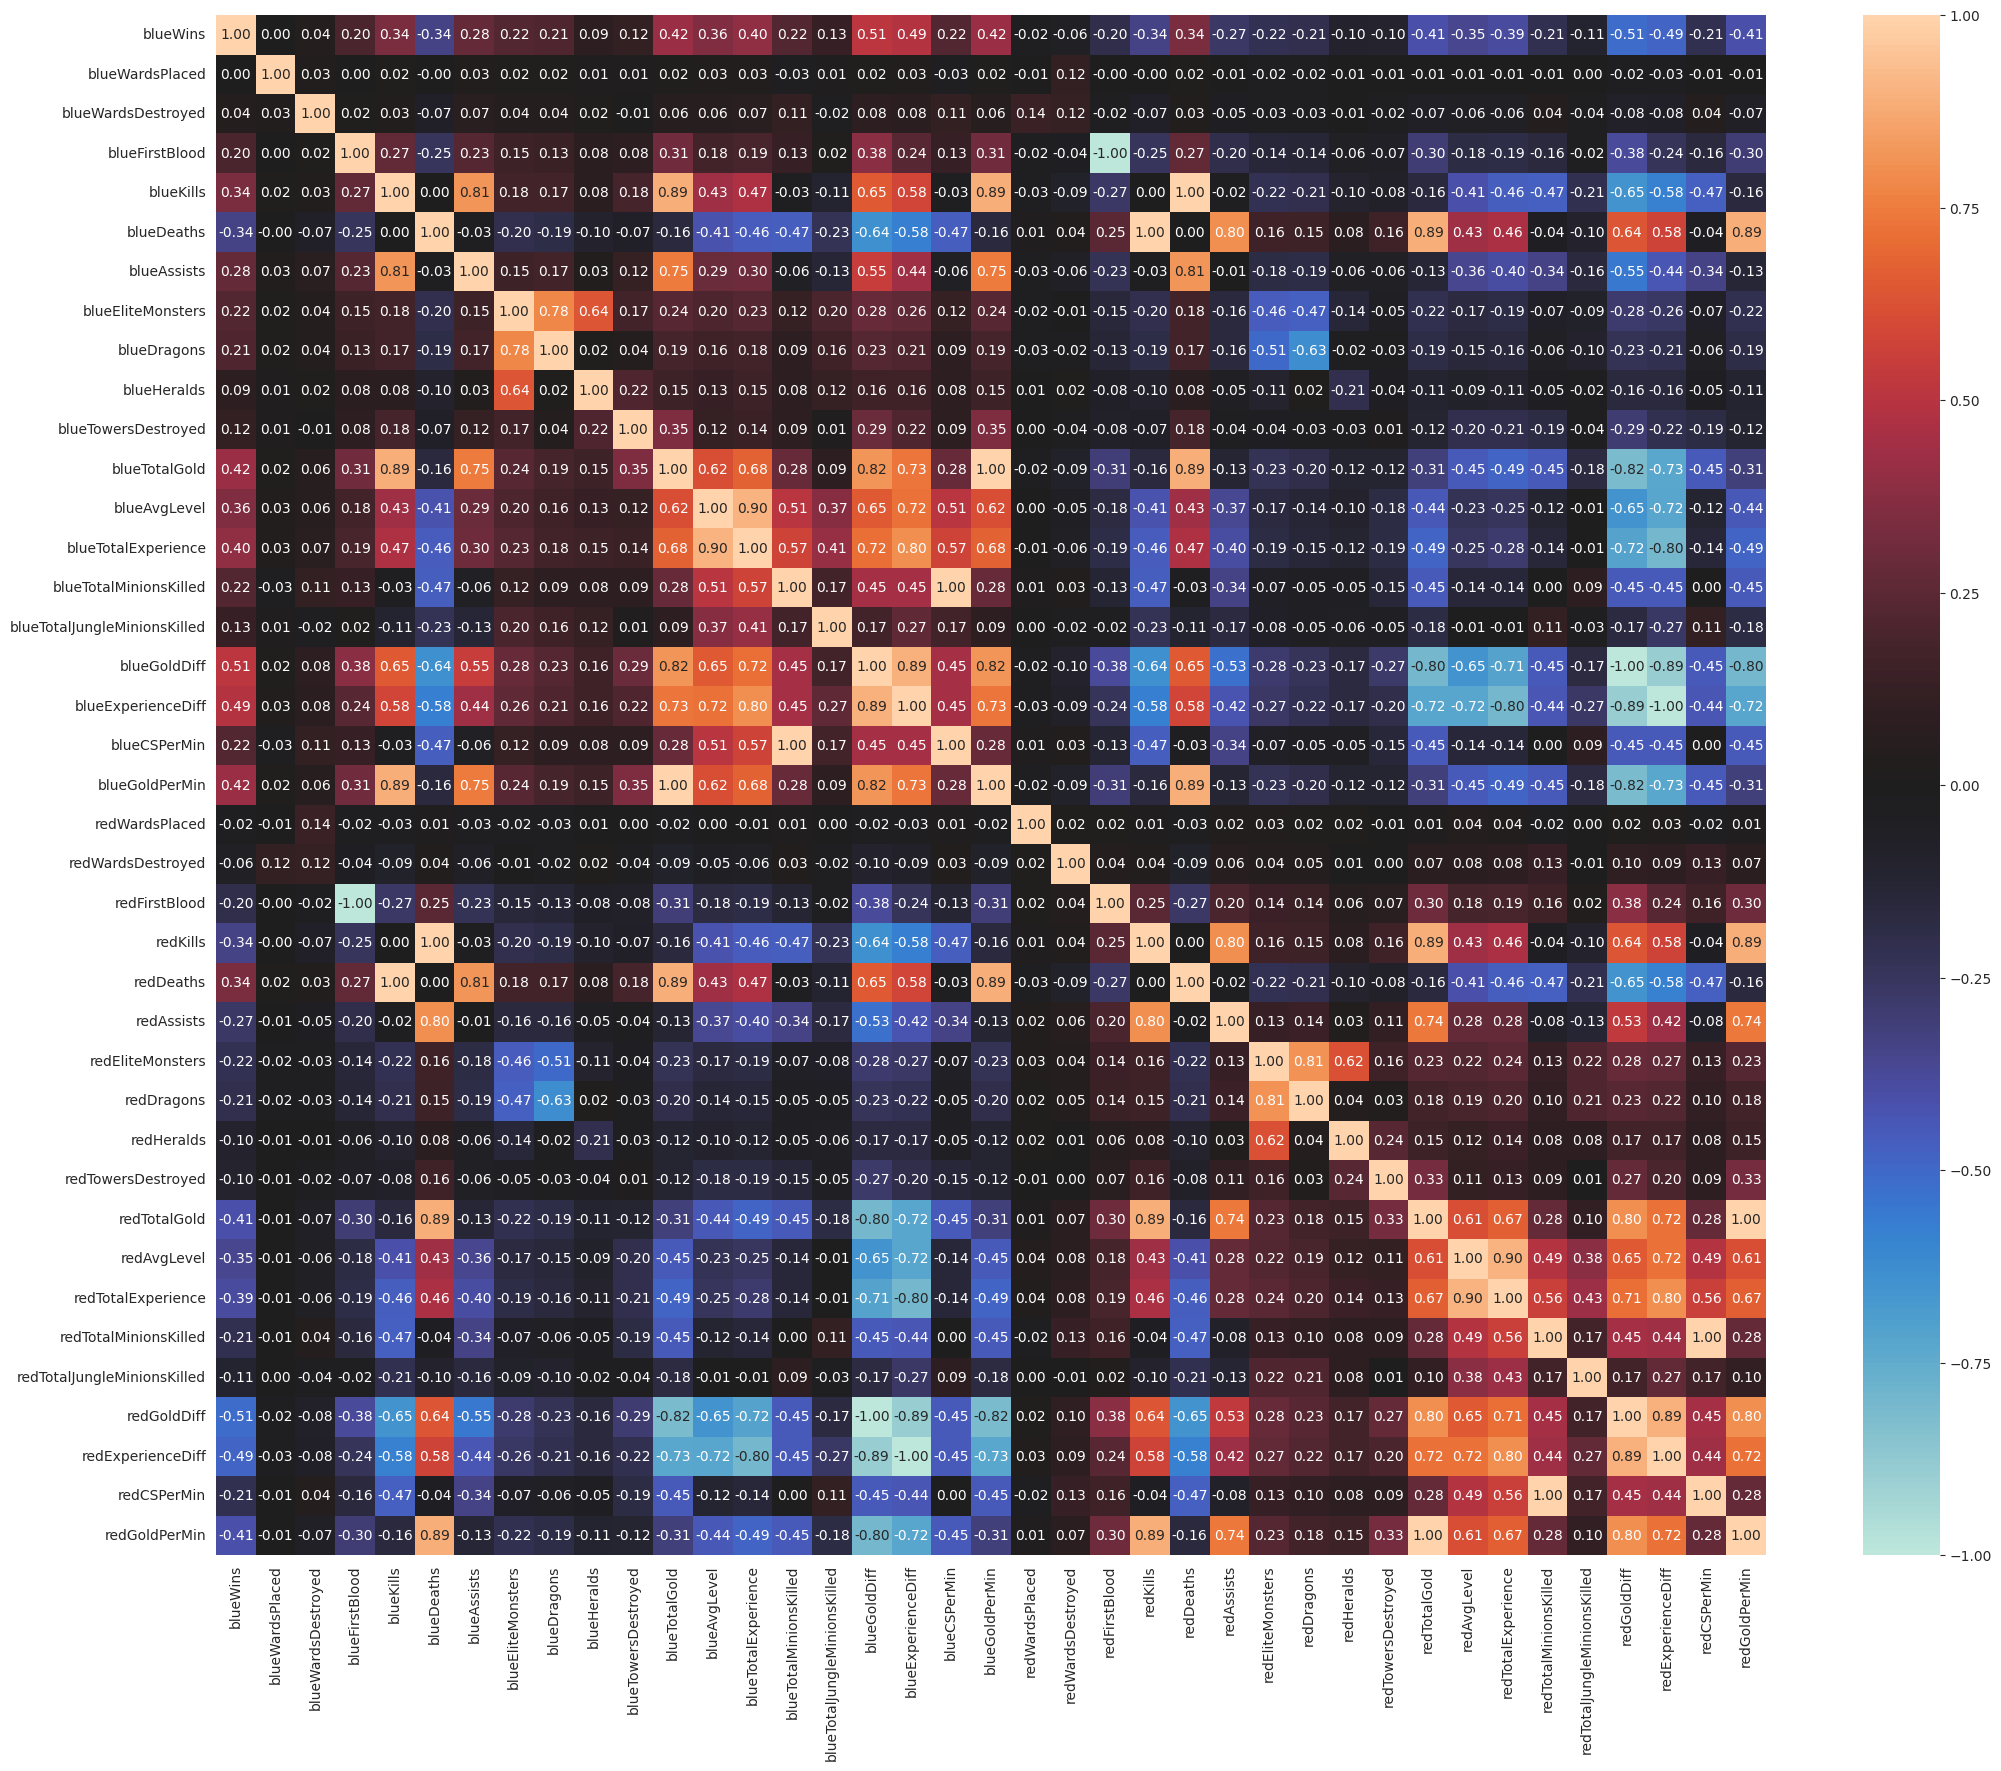

In [94]:
draw_correlation_matrix(data, figsize=(25, 20))

## Parameter selection

We can see from the correlation matrix the presence of some feature which are not correlated with others. Those are irrelevant to our model. Therefore, we removed all the columns which have their sum under a certain threshold.

In [95]:
correlation_matrix = data.corr()


column_to_drop = []
for column in correlation_matrix:
    correlation_index = correlation_matrix[column].abs().sum() - 1

    if correlation_index < 9:
        column_to_drop.append(column)

cleaned_data = data.drop(column_to_drop, axis=1)

#cleaned_data.head()
#cleaned_data.info()

discretized_cleaned_dataset = discretize_complete(cleaned_data)
discretized_cleaned_dataset.head()



,blueWins,blueKills,blueDeaths,blueAssists,blueTotalGold,blueAvgLevel,blueTotalExperience,blueGoldDiff,blueExperienceDiff,blueGoldPerMin,redKills,redDeaths,redAssists,redTotalGold,redAvgLevel,redTotalExperience,redGoldDiff,redExperienceDiff,redGoldPerMin
0,False,Positive,Positive,Positive,Very Positive,Neutral,Positive,Neutral,Neutral,Positive,Positive,Positive,Positive,Positive,Neutral,Positive,Neutral,Neutral,Positive
1,False,Neutral,Neutral,Neutral,Positive,Neutral,Neutral,Very Negative,Negative,Positive,Neutral,Neutral,Neutral,Very Positive,Neutral,Positive,Very Positive,Positive,Positive
2,False,Positive,Very Positive,Neutral,Positive,Neutral,Neutral,Negative,Negative,Positive,Very Positive,Positive,Very Positive,Very Positive,Neutral,Positive,Positive,Positive,Positive
3,False,Neutral,Neutral,Neutral,Positive,Neutral,Positive,Negative,Neutral,Positive,Neutral,Neutral,Positive,Positive,Neutral,Positive,Positive,Neutral,Positive
4,False,Positive,Positive,Neutral,Positive,Neutral,Very Positive,Negative,Neutral,Positive,Positive,Positive,Neutral,Very Positive,Neutral,Very Positive,Positive,Neutral,Positive


  0%|          | 0/2000 [00:00<?, ?it/s]

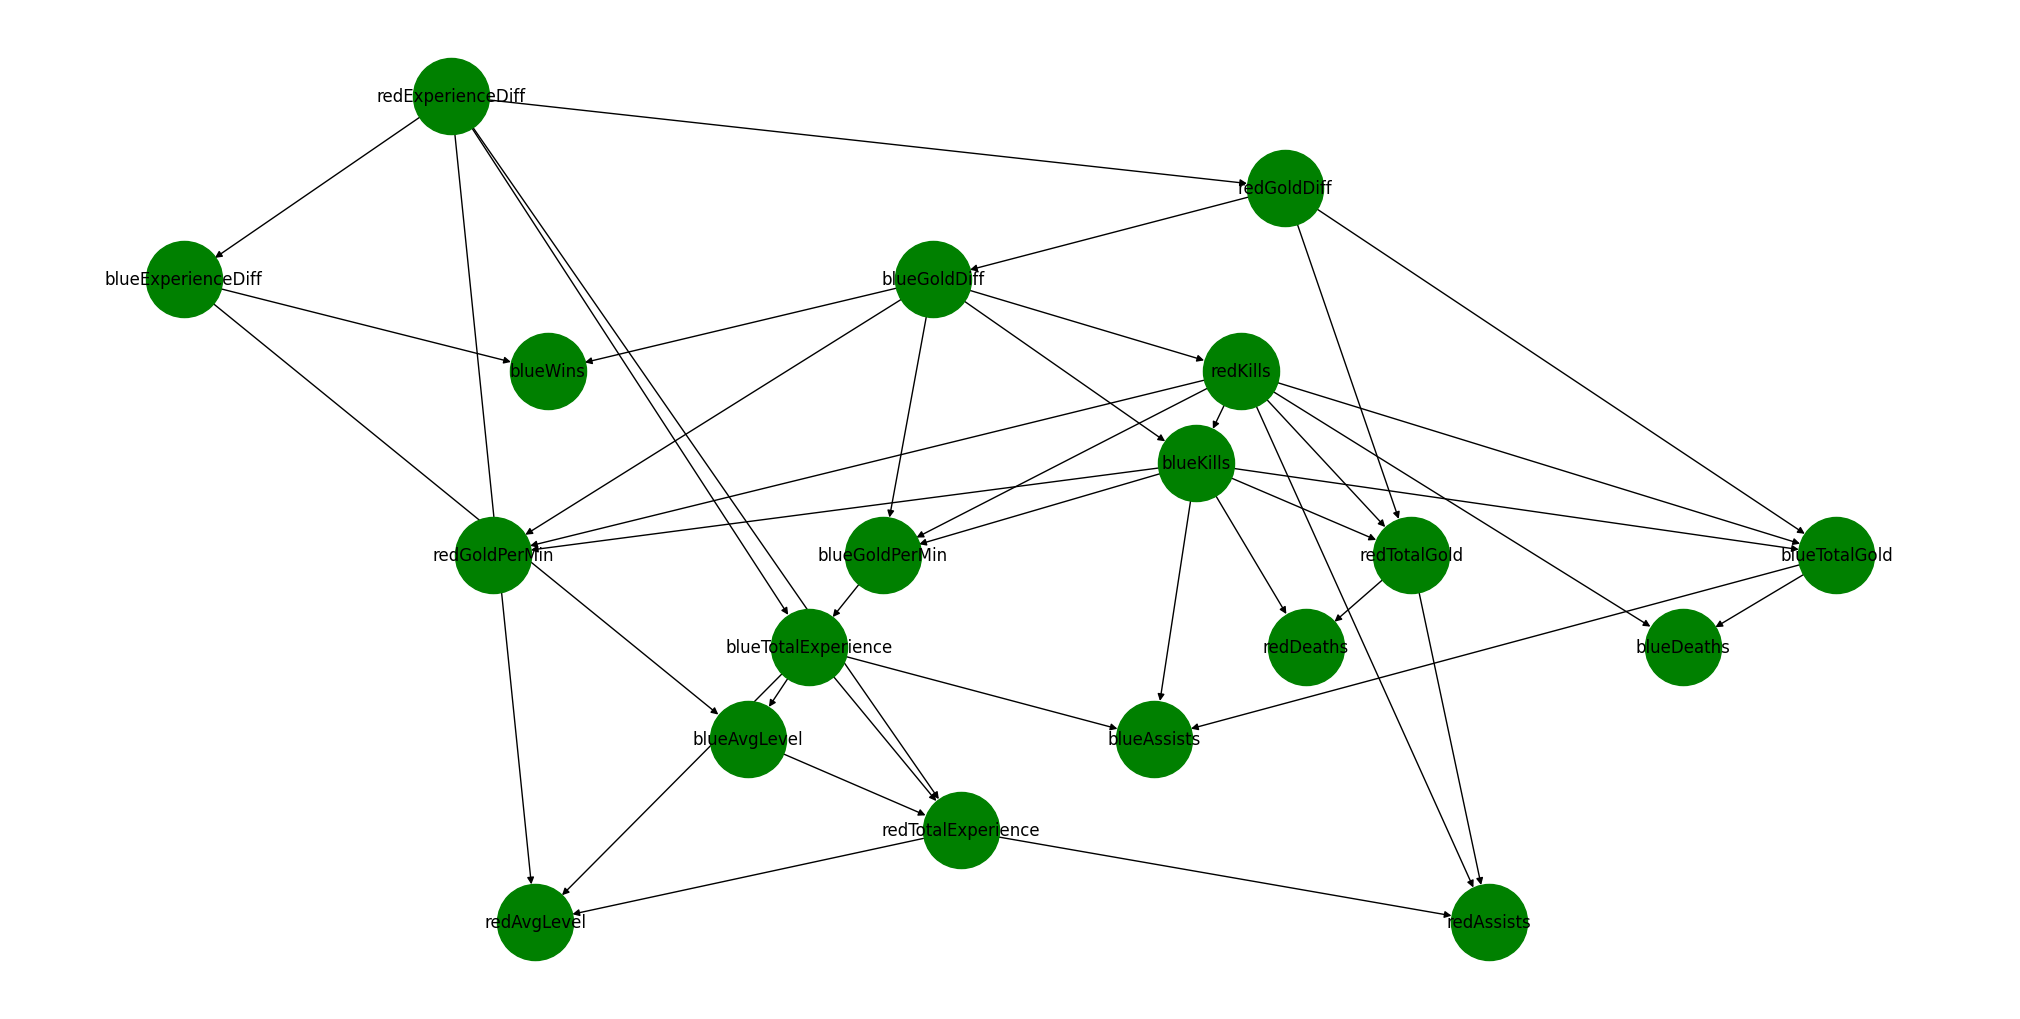

In [96]:
estimator_complete = HillClimbSearch(discretized_cleaned_dataset)


black_list_complete = [('blueWins', node) for node in discretized_cleaned_dataset.columns[:-1]]

hillclimb_model_complete = estimator_complete.estimate(scoring_method=BDsScore(discretized_cleaned_dataset), black_list=black_list_complete, max_iter=2000)
hillclimb_model_complete = BayesianNetwork(hillclimb_model_complete)
draw_graph(hillclimb_model_complete, figsize=(20, 10))


#ok?

In [97]:
hillclimb_model_complete.fit(data=discretized_cleaned_dataset,
            estimator=BayesianEstimator,
            prior_type="BDeu",
            equivalent_sample_size=10,
            complete_samples_only=False,
)

hillclimb_model_complete.check_model()

True

# Model comparisoon

Let's compare our models in terms of number of parameters and BDeu score.
BDeu score doesn't have a straight forward interpretebility. A higher score represents a better fit with the data.

In [103]:
def get_num_parameters(model): return sum(
    [len(cpd.get_values().ravel()) for cpd in model.get_cpds()])


models = [{"name": "manual model", "model": manual_model, "dataset": dataset},
          {"name": "hillclimb model", "model": hillclimb_model, "dataset": dataset},
          {"name": "hillclimb model complete", "model": hillclimb_model_complete, "dataset": discretized_cleaned_dataset},]


for model in models:
    print(f"Number of parameters in {model['name']}: {get_num_parameters(model['model'])}")


# N.B. the documentation for bic_score asserts that a model with a higher score fits the data better
for model in models:
    bdeu_score = BDeuScore(model["dataset"])
    print(f"BDeuScore in {model['name']}: {bdeu_score.score(model['model'])}")



Number of parameters in manual model: 717
Number of parameters in hillclimb model: 378
Number of parameters in hillclimb model complete: 1246
BDeuScore in manual model: -75443.70022216573
BDeuScore in hillclimb model: -69113.79852094335
BDeuScore in hillclimb model complete: -87539.38637369273


  0%|          | 0/2000 [00:00<?, ?it/s]

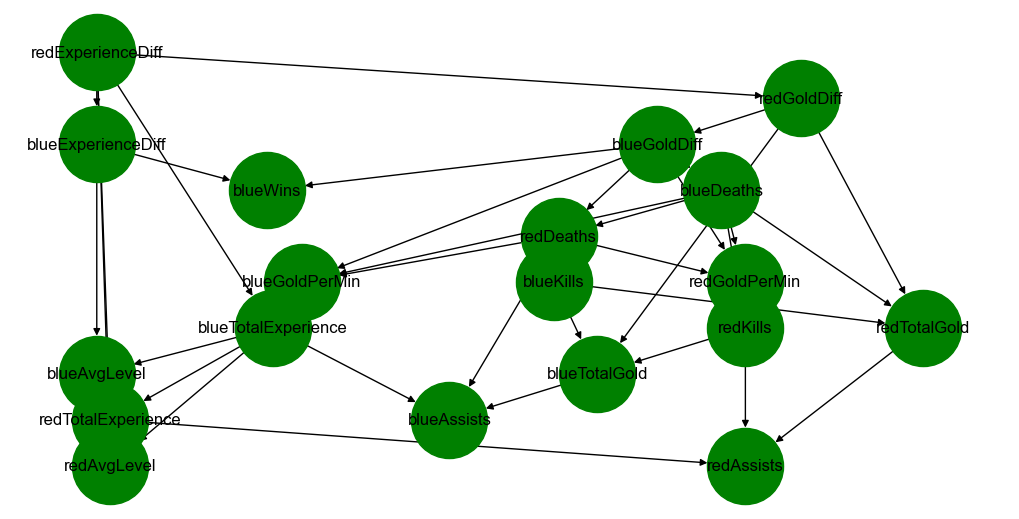

In [80]:
estimator_complete = HillClimbSearch(discretized_cleaned_dataset)


black_list_complete = [('blueWins', node) for node in discretized_cleaned_dataset.columns[:-1]]

hillclimb_model_complete = estimator_complete.estimate(scoring_method=BDsScore(discretized_cleaned_dataset), black_list=black_list_complete, max_iter=2000)
hillclimb_model_complete = BayesianNetwork(hillclimb_model_complete)
draw_graph(hillclimb_model_complete)

#ok?